# Preprocessing

In [1]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
import numpy as np

### COVID-19 Data - covid_df

In [2]:
# Import covid table as dataframe
con = sqlite3.connect("../Data/data.db")
covid_df = pd.read_sql_query("SELECT * FROM covid", con)
print(covid_df.dtypes)
print(covid_df.shape)
covid_df.head()

date                        object
state                       object
positiveIncrease             int64
totalTestResultsIncrease     int64
dtype: object
(18223, 4)


,date,state,positiveIncrease,totalTestResultsIncrease
0,2021-02-20 00:00:00,AK,0,0
1,2021-02-20 00:00:00,AL,774,5436
2,2021-02-20 00:00:00,AR,517,3060
3,2021-02-20 00:00:00,AZ,2047,45153
4,2021-02-20 00:00:00,CA,6668,192222


In [3]:
# Change date to datetime
covid_df = covid_df.drop(columns='totalTestResultsIncrease')
covid_df['date'] = pd.to_datetime(covid_df['date'])
print(covid_df.dtypes)
covid_df.head()

date                datetime64[ns]
state                       object
positiveIncrease             int64
dtype: object


,date,state,positiveIncrease
0,2021-02-20,AK,0
1,2021-02-20,AL,774
2,2021-02-20,AR,517
3,2021-02-20,AZ,2047
4,2021-02-20,CA,6668


In [4]:
# Define cutoff dates and encoding
months = [3,4,5,6,7,8,9]
start = [pd.Timestamp("3-15-2020"),
         pd.Timestamp("4-15-2020"),
         pd.Timestamp("5-15-2020"),
         pd.Timestamp("6-15-2020"),
         pd.Timestamp("7-15-2020"),
         pd.Timestamp("8-15-2020"),
         pd.Timestamp("9-15-2020")]
end = [pd.Timestamp("4-15-2020"),
       pd.Timestamp("5-15-2020"),
       pd.Timestamp("6-15-2020"),
       pd.Timestamp("7-15-2020"),
       pd.Timestamp("8-15-2020"),
       pd.Timestamp("9-15-2020"),
       pd.Timestamp("10-15-2020")]

# Include new month column
for i in range(len(months)):
    covid_df.loc[(covid_df['date']>=start[i]) & (covid_df['date']<end[i]), "month"] = months[i]

# Drop rows outside of daterange
covid_df = covid_df.dropna()
print(covid_df.shape)

covid_df.head()

(10914, 4)


,date,state,positiveIncrease,month
6579,2020-10-14,AK,155,9.0
6580,2020-10-14,AL,784,9.0
6581,2020-10-14,AR,1079,9.0
6582,2020-10-14,AZ,901,9.0
6583,2020-10-14,CA,2666,9.0


In [5]:
# Groupby state and month and sum
covid_df = covid_df.groupby(['state','month']).sum()
covid_df = covid_df.reset_index()
print(covid_df.shape)
covid_df.head()

(357, 3)


,state,month,positiveIncrease
0,AK,3.0,285
1,AK,4.0,104
2,AK,5.0,276
3,AK,6.0,915
4,AK,7.0,2498


In [6]:
# Calculate change in infections by state and month

# months = [4,5,6,7,8,9]
# states = covid_df['state'].unique()
# for month in months:
#     for state in states:
#         curr_month = covid_df[(covid_df['month'] == month) & (covid_df['state'] == state)].positiveIncrease.item()
#         prev_month = covid_df[(covid_df['month'] == month-1) & (covid_df['state'] == state)].positiveIncrease.item()
#         if prev_month != 0:
#             covid_df.loc[(covid_df['month'] == month) & (covid_df['state'] == state), 'covid_change'] = \
#             (curr_month-prev_month)/prev_month

covid_df = covid_df.sort_values(by=['state','month'])
covid_df['covid_change'] = covid_df['positiveIncrease'].pct_change()

# Keep data from Apr
covid_df = covid_df[covid_df['month']>=4]
print(covid_df.shape)
covid_df.head()

(306, 4)


,state,month,positiveIncrease,covid_change
1,AK,4.0,104,-0.635088
2,AK,5.0,276,1.653846
3,AK,6.0,915,2.315217
4,AK,7.0,2498,1.730055
5,AK,8.0,2272,-0.090472


In [7]:
# Get population of states
pop_df = pd.read_sql_query("SELECT state, population FROM policy", con)
pop_df.head()

,state,population
0,AL,4887871
1,AK,737438
2,AZ,7171646
3,AR,3013825
4,CA,39557045


In [8]:
# Merge tables
covid_df = pd.merge(covid_df, pop_df, on='state')
covid_df.head()

,state,month,positiveIncrease,covid_change,population
0,AK,4.0,104,-0.635088,737438
1,AK,5.0,276,1.653846,737438
2,AK,6.0,915,2.315217,737438
3,AK,7.0,2498,1.730055,737438
4,AK,8.0,2272,-0.090472,737438


In [9]:
# Calculate new cases per capita
covid_df['per_capita'] = covid_df['positiveIncrease']/covid_df['population']
covid_df = covid_df.astype({'month':'int64'})
covid_df = covid_df.drop(columns='population')
print(covid_df.shape)
print(covid_df.dtypes)
covid_df.head()

(306, 5)
state                object
month                 int64
positiveIncrease      int64
covid_change        float64
per_capita          float64
dtype: object


,state,month,positiveIncrease,covid_change,per_capita
0,AK,4,104,-0.635088,0.000141
1,AK,5,276,1.653846,0.000374
2,AK,6,915,2.315217,0.001241
3,AK,7,2498,1.730055,0.003387
4,AK,8,2272,-0.090472,0.003081


### Policy Data - policy_df

In [10]:
raw = pd.read_sql_query("SELECT * FROM policy", con)
# Drop pop density and population columns 
raw = raw.drop(columns=['pop_density', 'population'])
print(raw.dtypes)
raw.head()

state                    object
state_of_emergency       object
stay_at_home             object
stay_at_home_end         object
business_closure         object
business_closure_end     object
facemask_mandate         object
facemask_mandate_end     object
quaratine_mandate        object
quaratine_mandate_end    object
dtype: object


,state,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
0,AL,2020-03-13 00:00:00,2020-04-04 00:00:00,2020-04-30 00:00:00,2020-03-28 00:00:00,2020-04-30 00:00:00,2020-07-16 00:00:00,None,None,None
1,AK,2020-03-11 00:00:00,2020-03-28 00:00:00,2020-04-24 00:00:00,2020-03-24 00:00:00,2020-04-24 00:00:00,2020-04-24 00:00:00,2020-05-22 00:00:00,2020-03-25 00:00:00,2021-02-14 00:00:00
2,AZ,2020-03-11 00:00:00,2020-03-31 00:00:00,2020-05-16 00:00:00,2020-03-31 00:00:00,2020-05-08 00:00:00,None,None,None,2020-05-12 00:00:00
3,AR,2020-03-11 00:00:00,None,None,2020-04-06 00:00:00,2020-05-04 00:00:00,2020-07-20 00:00:00,None,None,2020-06-15 00:00:00
4,CA,2020-03-04 00:00:00,2020-03-19 00:00:00,None,2020-03-19 00:00:00,2020-05-08 00:00:00,2020-06-18 00:00:00,None,None,None


In [11]:
# Change columns to Datetime object, convert date to only the month value
for i in range(1, raw.shape[1]):
    raw.iloc[:, i] = pd.to_datetime(raw.iloc[:, i], errors="coerce")
    for j in range(0, raw.shape[0]): 
        # Set month to inf if it is out of range of 2020
        if raw.iloc[j, i].year == 2021:
            raw.iloc[j, i] = np.inf
        else:
            raw.iloc[j, i] = raw.iloc[j, i].month
print(raw.dtypes)
raw = raw.fillna(np.Inf)
raw.head()

state                    object
state_of_emergency       object
stay_at_home             object
stay_at_home_end         object
business_closure         object
business_closure_end     object
facemask_mandate         object
facemask_mandate_end     object
quaratine_mandate        object
quaratine_mandate_end    object
dtype: object


,state,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
0,AL,3,4.0,4.0,3.0,4.0,7.0,inf,inf,inf
1,AK,3,3.0,4.0,3.0,4.0,4.0,5.0,3.0,inf
2,AZ,3,3.0,5.0,3.0,5.0,inf,inf,inf,5.0
3,AR,3,inf,inf,4.0,5.0,7.0,inf,inf,6.0
4,CA,3,3.0,inf,3.0,5.0,6.0,inf,inf,inf


In [12]:
# Encode data where 1 indicates that policy is active and 2 indicates that policy is inactive
policy_df = pd.DataFrame(columns = ['state','month','state_of_emergency','stay_at_home', \
                                         'business_closure','facemask_mandate','quarantine_mandate'])
months = [4,5,6,7,8,9]
states = covid_df['state'].unique()
for month in months:
    for state in states:
        row = raw[raw['state'] == state]
        emergency, home, business, facemask, quarantine = 0, 0, 0, 0, 0
        # Encode as 1 if month is between start and end
        if month >= row.state_of_emergency.item():
            emergency = 1
        if month >= row.stay_at_home.item() and month <= row.stay_at_home_end.item():
            home = 1
        if month >= row.business_closure.item() and month <= row.business_closure_end.item():
            business = 1
        if month >= row.facemask_mandate.item() and month <= row.facemask_mandate_end.item():
            facemask = 1
        if month >= row.quaratine_mandate.item() and month <= row.quaratine_mandate_end.item():
            quarantine = 1
        # Add to dataframe
        policy_df = policy_df.append({'state':state,\
                                                'month':month,\
                                                'state_of_emergency':emergency,\
                                                'stay_at_home':home,\
                                                'business_closure':business,\
                                                'facemask_mandate':facemask,\
                                                'quarantine_mandate':quarantine}, ignore_index=True)
print(policy_df.dtypes)
policy_df.head()

state                 object
month                 object
state_of_emergency    object
stay_at_home          object
business_closure      object
facemask_mandate      object
quarantine_mandate    object
dtype: object


,state,month,state_of_emergency,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
0,AK,4,1,1,1,1,1
1,AL,4,1,1,1,0,0
2,AR,4,1,0,1,0,0
3,AZ,4,1,1,1,0,0
4,CA,4,1,1,1,0,0


### Data Exploration

In [13]:
policy_df = policy_df.astype('int',errors='ignore')
# Check variance of data
print(policy_df.var())
policy_df = policy_df.drop(columns='state_of_emergency')

month                 2.926230
state_of_emergency    0.000000
stay_at_home          0.222951
business_closure      0.219576
facemask_mandate      0.250134
quarantine_mandate    0.143673
dtype: float64


In [14]:
policy_df[['stay_at_home','business_closure','facemask_mandate','quarantine_mandate']].corr()

,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
stay_at_home,1.000000,0.711287,-0.087931,0.079383
business_closure,0.711287,1.000000,-0.250588,0.071123
facemask_mandate,-0.087931,-0.250588,1.000000,0.170974
quarantine_mandate,0.079383,0.071123,0.170974,1.000000


### Flight Data - flight_df

In [15]:
flight_df = pd.read_sql_query("SELECT * FROM flight WHERE (month >= 3)", con)
flight_df.head()

,origin_state,dest_state,month,monthly_pax
0,AK,AK,3.0,56336.281143
1,AK,AK,4.0,10187.576905
2,AK,AK,5.0,20472.748260
3,AK,AK,6.0,41179.674835
4,AK,AK,7.0,52228.927140


# Hypothesis 1 - Simple Regression of Flight monthly_pax against positiveIncrease


In [16]:
# Find total number of incoming flights for each state
flight_dest_state = flight_df.groupby(['dest_state', 'month']).sum().reset_index()
flight_dest_state = flight_dest_state.rename(columns={'dest_state':'state'})
print(flight_dest_state.shape)
flight_dest_state.head()

(364, 3)


,state,month,monthly_pax
0,AK,3.0,138235.631149
1,AK,4.0,26092.783185
2,AK,5.0,52663.559269
3,AK,6.0,110763.657546
4,AK,7.0,158323.464182


In [17]:
flight_dest_state = flight_dest_state.sort_values(by=['state','month'])
flight_dest_state['flight_change'] = flight_dest_state['monthly_pax'].pct_change()
flight_dest_state = flight_dest_state[flight_dest_state['month']>=4]
flight_dest_state.head()

,state,month,monthly_pax,flight_change
1,AK,4.0,26092.783185,-0.811244
2,AK,5.0,52663.559269,1.018319
3,AK,6.0,110763.657546,1.103232
4,AK,7.0,158323.464182,0.429381
5,AK,8.0,151104.177926,-0.045598


In [18]:
# Combine covid and flight data
model1_df = covid_df.merge(flight_dest_state, how="inner", on=['state', 'month'])
print(model1_df.shape)
model1_df.head()

(294, 7)


,state,month,positiveIncrease,covid_change,per_capita,monthly_pax,flight_change
0,AK,4,104,-0.635088,0.000141,26092.783185,-0.811244
1,AK,5,276,1.653846,0.000374,52663.559269,1.018319
2,AK,6,915,2.315217,0.001241,110763.657546,1.103232
3,AK,7,2498,1.730055,0.003387,158323.464182,0.429381
4,AK,8,2272,-0.090472,0.003081,151104.177926,-0.045598


In [19]:
# Fit linear regression model
model = sm.OLS(model1_df['positiveIncrease'],sm.add_constant(model1_df['monthly_pax']))
# model = sm.OLS(model1_df['covid_change'],sm.add_constant(model1_df['flight_change']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       positiveIncrease   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     458.8
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           7.79e-62
Time:                        11:27:11   Log-Likelihood:                -3379.7
No. Observations:                 294   AIC:                             6763.
Df Residuals:                     292   BIC:                             6771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4895.0449   1663.104      2.943      

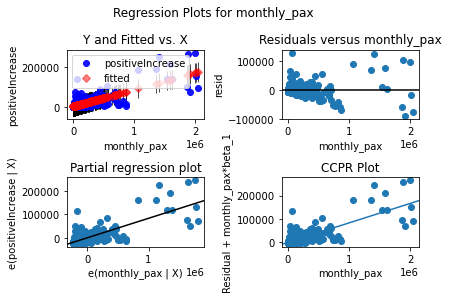

In [20]:
fig = sm.graphics.plot_regress_exog(results, "monthly_pax")
fig.tight_layout(pad=1.0)

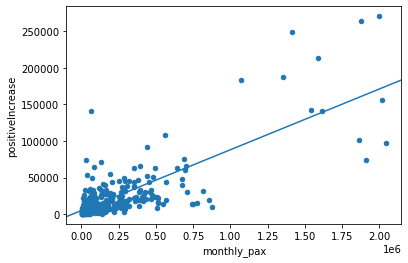

In [21]:
from statsmodels.graphics.regressionplots import abline_plot
# scatter-plot data
ax = model1_df.plot(x='monthly_pax', y='positiveIncrease', kind='scatter')

# plot regression line
fig = abline_plot(model_results=results, ax=ax)

In [22]:
results.params

const          4895.044918
monthly_pax       0.083107
dtype: float64

In [23]:
results.pvalues

const          3.507764e-03
monthly_pax    7.785749e-62
dtype: float64

# Hypothesis 2 - Simple Regression of weighted flight monthly_pax against positiveIncrease

In [24]:
# Multiply monthly_pax with origin_state's per_capita
flight_df = flight_df[flight_df['month']>=4]
flights_weighted = flight_df.merge(covid_df, how="left", left_on=['origin_state', 'month'], right_on=['state','month'])
flights_weighted['weighted_pax'] = flights_weighted['monthly_pax']*flights_weighted['per_capita']
flights_weighted.head()

,origin_state,dest_state,month,monthly_pax,state,positiveIncrease,covid_change,per_capita,weighted_pax
0,AK,AK,4.0,10187.576905,AK,104.0,-0.635088,0.000141,1.436742
1,AK,AK,5.0,20472.748260,AK,276.0,1.653846,0.000374,7.662310
2,AK,AK,6.0,41179.674835,AK,915.0,2.315217,0.001241,51.095011
3,AK,AK,7.0,52228.927140,AK,2498.0,1.730055,0.003387,176.920446
4,AK,AK,8.0,50918.481872,AK,2272.0,-0.090472,0.003081,156.876633


In [25]:
# Aggregate by dest_state
flights_weighted = flights_weighted.groupby(['dest_state', 'month']).sum().reset_index()
flights_weighted = flights_weighted.rename(columns={'dest_state':'state'})
flights_weighted = flights_weighted[['state','month','weighted_pax']]
print(flights_weighted.shape)
flights_weighted.head()

(312, 3)


,state,month,weighted_pax
0,AK,4.0,25.351912
1,AK,5.0,60.627639
2,AK,6.0,329.105647
3,AK,7.0,738.584167
4,AK,8.0,501.866129


In [26]:
# Combine covid and flight data
model2_df = covid_df.merge(flights_weighted, how="inner", on=['state', 'month'])
print(model2_df.shape)
model2_df.head()

(294, 6)


,state,month,positiveIncrease,covid_change,per_capita,weighted_pax
0,AK,4,104,-0.635088,0.000141,25.351912
1,AK,5,276,1.653846,0.000374,60.627639
2,AK,6,915,2.315217,0.001241,329.105647
3,AK,7,2498,1.730055,0.003387,738.584167
4,AK,8,2272,-0.090472,0.003081,501.866129


In [28]:
# Export for data visualization
model2_df.to_csv("../Data/viz/analysis.csv")

In [29]:
# Fit linear regression model
model = sm.OLS(model2_df['positiveIncrease'],sm.add_constant(model2_df['weighted_pax']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       positiveIncrease   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     472.0
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           6.16e-63
Time:                        11:27:33   Log-Likelihood:                -3377.2
No. Observations:                 294   AIC:                             6758.
Df Residuals:                     292   BIC:                             6766.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5561.5213   1629.539      3.413   

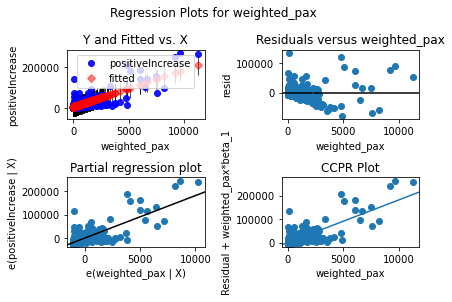

In [30]:
fig = sm.graphics.plot_regress_exog(results, "weighted_pax")
fig.tight_layout(pad=1.0)

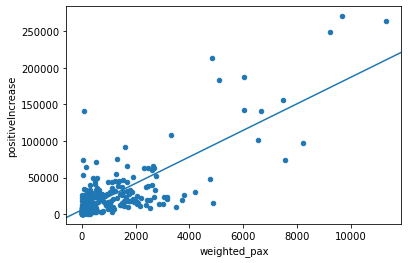

In [31]:
from statsmodels.graphics.regressionplots import abline_plot
# scatter-plot data
ax = model2_df.plot(x='weighted_pax', y='positiveIncrease', kind='scatter')

# plot regression line
fig = abline_plot(model_results=results, ax=ax)

In [32]:
results.params

const           5561.521315
weighted_pax      18.190695
dtype: float64

In [33]:
results.pvalues

const           7.335090e-04
weighted_pax    6.155581e-63
dtype: float64

# Hypothesis 3 - Adding in Controls

### monthly_pax

In [34]:
# Merge with policy table
monthly_control = model1_df.merge(policy_df, how="inner", on=['state', 'month'])
print(monthly_control.shape)
monthly_control.head()

(294, 11)


,state,month,positiveIncrease,covid_change,per_capita,monthly_pax,flight_change,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
0,AK,4,104,-0.635088,0.000141,26092.783185,-0.811244,1,1,1,1
1,AK,5,276,1.653846,0.000374,52663.559269,1.018319,0,0,1,1
2,AK,6,915,2.315217,0.001241,110763.657546,1.103232,0,0,0,1
3,AK,7,2498,1.730055,0.003387,158323.464182,0.429381,0,0,0,1
4,AK,8,2272,-0.090472,0.003081,151104.177926,-0.045598,0,0,0,1


In [35]:
# Fit linear regression model
variables= ['monthly_pax','stay_at_home','business_closure','facemask_mandate','quarantine_mandate']
model = sm.OLS(monthly_control['positiveIncrease'],sm.add_constant(monthly_control[variables]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       positiveIncrease   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     95.06
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           7.21e-59
Time:                        11:27:37   Log-Likelihood:                -3375.3
No. Observations:                 294   AIC:                             6763.
Df Residuals:                     288   BIC:                             6785.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5569.4058   2566

In [36]:
results.params

const                 5569.405756
monthly_pax              0.082998
stay_at_home          5142.241107
business_closure       253.985592
facemask_mandate     -2590.912068
quarantine_mandate   -7381.777483
dtype: float64

In [37]:
results.pvalues

const                 3.080139e-02
monthly_pax           1.569867e-56
stay_at_home          2.212651e-01
business_closure      9.544661e-01
facemask_mandate      3.863172e-01
quarantine_mandate    5.646706e-02
dtype: float64

### weighted_pax

In [38]:
# Merge with policy table
weighted_control = model2_df.merge(policy_df, how="inner", on=['state', 'month'])
print(weighted_control.shape)
weighted_control.head()

(294, 10)


,state,month,positiveIncrease,covid_change,per_capita,weighted_pax,stay_at_home,business_closure,facemask_mandate,quarantine_mandate
0,AK,4,104,-0.635088,0.000141,25.351912,1,1,1,1
1,AK,5,276,1.653846,0.000374,60.627639,0,0,1,1
2,AK,6,915,2.315217,0.001241,329.105647,0,0,0,1
3,AK,7,2498,1.730055,0.003387,738.584167,0,0,0,1
4,AK,8,2272,-0.090472,0.003081,501.866129,0,0,0,1


In [39]:
# Fit linear regression model
variables= ['weighted_pax','stay_at_home','business_closure','facemask_mandate','quarantine_mandate']
model = sm.OLS(weighted_control['positiveIncrease'],sm.add_constant(weighted_control[variables]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       positiveIncrease   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     103.1
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           4.73e-62
Time:                        11:27:38   Log-Likelihood:                -3367.7
No. Observations:                 294   AIC:                             6747.
Df Residuals:                     288   BIC:                             6770.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5121.2807   2502

In [40]:
results.params

const                 5121.280687
weighted_pax            18.876066
stay_at_home          6476.312352
business_closure      3325.615469
facemask_mandate     -5350.178716
quarantine_mandate   -6235.778420
dtype: float64

In [41]:
results.pvalues

const                 4.161878e-02
weighted_pax          9.689724e-60
stay_at_home          1.138444e-01
business_closure      4.463402e-01
facemask_mandate      6.907961e-02
quarantine_mandate    9.888619e-02
dtype: float64